In [1]:
# import networkx as nx
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 网络数据导入为numpy数组
dataFile_1 = '../data/WS_2000_4_03.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'])
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../data/WS_2000_4_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'])
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"
assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"
if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [4]:
# 参数设置

# random.seed(256)       #指定生成“特定”的随机数
# np.random.seed(256)

# 0. 公共参数
Monte_Carlo_loop = 150      # 蒙特卡洛模拟次数
time_steps = 100           # 总时间步数
N = network_scale_1[0]     # 网络节点数

# # 1. SIS参数
# bata = 0.2    # 感染概率
# mu = 0.4      # 恢复概率

# Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])       # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态

# infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
# infective_count_average = np.zeros([1, time_steps])

# # 2. UAU参数
# lamda = 0.3    # 传播率
# delta = 0.6    # 遗忘率

# Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])       # 存储网络中每个节点的知情状态快照

# awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
# awareness_count_average = np.zeros([1, time_steps])

# 3. 节点警觉状态
# alert = 0.8
alerts = [0.1, 0.2, 0.4, 0.6, 0.8, 1]

# Node_alert = np.zeros([Monte_Carlo_loop, time_steps, N])      # 存储网络中每个节点的活跃状态快照
# alert_count = np.zeros([Monte_Carlo_loop, time_steps])        # 每步知晓节点数量,用于最终统计
# alert_count_average = np.zeros([1, time_steps])

# # 4. 其他参数
# aplha = 0.4      # 信息上传率
# sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触

# 5. 感染范围信息
i_t = np.zeros([len(alerts), time_steps])

In [5]:
time_start_outter = time.time()

for a in range(len(alerts)):
    alert = alerts[a]
    inalert = 1 - alert
    
    random.seed(256)       #指定生成“特定”的随机数
    np.random.seed(256)

    # 1. SIS参数
    bata = 0.2    # 感染概率
    mu = 0.4      # 恢复概率

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])       # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])

    # 2. UAU参数
    lamda = 0.3    # 传播率
    delta = 0.6    # 遗忘率

    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])       # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])

    # 3. 节点警觉状态
    # alert = 0.8
    # alerts = [0.1, 0.2, 0.4, 0.6, 0.8, 1]

    Node_alert = np.zeros([Monte_Carlo_loop, time_steps, N])      # 存储网络中每个节点的活跃状态快照
    alert_count = np.zeros([Monte_Carlo_loop, time_steps])        # 每步知晓节点数量,用于最终统计
    alert_count_average = np.zeros([1, time_steps])

    # 4. 其他参数
    aplha = 0.4      # 信息上传率
    sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触

    time_start_inner = time.time()
    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1     # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1     # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        # 初始节点依概率变得警觉
        p0 = np.random.rand(1)
        if p0 < alert:
            Node_alert[loop, 0, p] = 1    # 初始节点变得警觉


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]         # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]            # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)                         # 统计数量

                    # -----UAU传播过程-----
                    aware_rate = lamda
                    aware_temp = (1 - aware_rate) ** Num_neighbor_listener    # 最终计算的传播率
                    a1 = 1 - aware_temp

                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a1:
                        Nodes_UAU[loop, t+1, i] = 1

                        # 已知的节点如果是非警觉的，节点依概率变得警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 已知的节点如果是警觉的，保持警觉
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A1!")

                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                        # 继续保持U的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 已知的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A2!")


                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘

                        # 遗忘的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 遗忘的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A3!")

                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉

                        # 遗忘失败且非警觉，依旧有概率变为警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 遗忘失败且已经警觉，警觉性保持不变（只有A->U才会变化） 
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A4!")   


            # ----------SIS演化----------
            for i in range(N):

                # 0代表易感(S)，如果节点i健康且非警觉，就查找其I状态的邻居（非警觉节点处理方式不变-与所有结节点触）
                if ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 0)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]            # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]            # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)   # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)                       # 统计数量

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1                 # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                    # -----SIS感染过程1-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1

                            # 成功感染的节点下一时刻依概率变得警觉
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉
                            else:
                                Node_alert[loop, t+1, i] = 0
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # 0代表易感(S)，如果节点i健康且警觉，就查找其I状态的警觉邻居
                elif ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 感染节点
                    alert_nodes = np.where((Node_alert[loop, t, :] == 0))[0]       # 非警觉节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)          # 取交集，真正可以感染它的邻居
                    neighbor_infective_alert = np.intersect1d(neighbor_infective, alert_nodes)    # 取交集，真正可以感染它的警觉邻居

                    Num_neighbor_infective_alert = len(neighbor_infective_alert)                  # 统计

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1                 # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert


                    # -----SIS感染过程2-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                    # S节点已经是警觉节点，被感染后继续保持警觉
                    Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")
            
        print("    loop_MC {} - time has passed: {} ".format(loop, time.time()-time_start_inner))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
        # awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)
        # alert_count[loop_,:] = np.sum(Node_alert[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
    # awareness_count_average = np.mean(awareness_count, axis=0)
    # alert_count_average = np.mean(alert_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
    # assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"
    # assert alert_count_average.shape == (time_steps,), "alert_count_average\'s size don\'t match!"

    i_t_a = infective_count_average/N
    i_t[a] = i_t_a

    print("loop_a {} - time has passed: {} ".format(a, time.time()-time_start_outter))

    loop_MC 0 - time has passed: 34.84824228286743 
    loop_MC 1 - time has passed: 65.12073135375977 
    loop_MC 2 - time has passed: 108.85143995285034 
    loop_MC 3 - time has passed: 147.13619446754456 
    loop_MC 4 - time has passed: 183.9677073955536 
    loop_MC 5 - time has passed: 221.38716530799866 
    loop_MC 6 - time has passed: 254.87970542907715 
    loop_MC 7 - time has passed: 291.5227644443512 
    loop_MC 8 - time has passed: 328.34977674484253 
    loop_MC 9 - time has passed: 359.85029435157776 
    loop_MC 10 - time has passed: 398.32989048957825 
    loop_MC 11 - time has passed: 429.5097219944 
    loop_MC 12 - time has passed: 463.3046154975891 
    loop_MC 13 - time has passed: 497.9353790283203 
    loop_MC 14 - time has passed: 531.4497919082642 
    loop_MC 15 - time has passed: 556.2711315155029 
    loop_MC 16 - time has passed: 592.3273892402649 
    loop_MC 17 - time has passed: 626.3377225399017 
    loop_MC 18 - time has passed: 663.9561133384705 

    loop_MC 3 - time has passed: 81.33117866516113 
    loop_MC 4 - time has passed: 100.729088306427 
    loop_MC 5 - time has passed: 115.34248900413513 
    loop_MC 6 - time has passed: 133.98231196403503 
    loop_MC 7 - time has passed: 152.56643104553223 
    loop_MC 8 - time has passed: 171.52145719528198 
    loop_MC 9 - time has passed: 190.51610279083252 
    loop_MC 10 - time has passed: 208.58056592941284 
    loop_MC 11 - time has passed: 227.28185725212097 
    loop_MC 12 - time has passed: 246.37500381469727 
    loop_MC 13 - time has passed: 265.8597695827484 
    loop_MC 14 - time has passed: 284.53233790397644 
    loop_MC 15 - time has passed: 303.2013111114502 
    loop_MC 16 - time has passed: 321.9648241996765 
    loop_MC 17 - time has passed: 336.8319652080536 
    loop_MC 18 - time has passed: 356.1358585357666 
    loop_MC 19 - time has passed: 374.77108240127563 
    loop_MC 20 - time has passed: 393.6810438632965 
    loop_MC 21 - time has passed: 412.728481

    loop_MC 5 - time has passed: 107.65404033660889 
    loop_MC 6 - time has passed: 124.99898624420166 
    loop_MC 7 - time has passed: 138.8137092590332 
    loop_MC 8 - time has passed: 156.47607564926147 
    loop_MC 9 - time has passed: 173.98409867286682 
    loop_MC 10 - time has passed: 191.38653302192688 
    loop_MC 11 - time has passed: 209.07495069503784 
    loop_MC 12 - time has passed: 226.92629504203796 
    loop_MC 13 - time has passed: 246.14230012893677 
    loop_MC 14 - time has passed: 927.2490420341492 
    loop_MC 15 - time has passed: 945.2107589244843 
    loop_MC 16 - time has passed: 963.7172753810883 
    loop_MC 17 - time has passed: 980.0585482120514 
    loop_MC 18 - time has passed: 999.648167848587 
    loop_MC 19 - time has passed: 1019.1027336120605 
    loop_MC 20 - time has passed: 1039.7095823287964 
    loop_MC 21 - time has passed: 1058.610065460205 
    loop_MC 22 - time has passed: 1077.020789384842 
    loop_MC 23 - time has passed: 1096.397

    loop_MC 7 - time has passed: 198.07434558868408 
    loop_MC 8 - time has passed: 221.81982851028442 
    loop_MC 9 - time has passed: 248.06063151359558 
    loop_MC 10 - time has passed: 272.4902832508087 
    loop_MC 11 - time has passed: 297.9551646709442 
    loop_MC 12 - time has passed: 316.806734085083 
    loop_MC 13 - time has passed: 340.82149600982666 
    loop_MC 14 - time has passed: 368.6241226196289 
    loop_MC 15 - time has passed: 391.8839020729065 
    loop_MC 16 - time has passed: 417.637011051178 
    loop_MC 17 - time has passed: 438.5650291442871 
    loop_MC 18 - time has passed: 458.25087785720825 
    loop_MC 19 - time has passed: 480.6748924255371 
    loop_MC 20 - time has passed: 497.2994210720062 
    loop_MC 21 - time has passed: 517.5756387710571 
    loop_MC 22 - time has passed: 538.8237991333008 
    loop_MC 23 - time has passed: 560.5668697357178 
    loop_MC 24 - time has passed: 582.8462734222412 
    loop_MC 25 - time has passed: 604.42056179

    loop_MC 9 - time has passed: 201.8299629688263 
    loop_MC 10 - time has passed: 221.68937873840332 
    loop_MC 11 - time has passed: 243.28714632987976 
    loop_MC 12 - time has passed: 264.7387340068817 
    loop_MC 13 - time has passed: 289.98619389533997 
    loop_MC 14 - time has passed: 317.53350257873535 
    loop_MC 15 - time has passed: 343.75835061073303 
    loop_MC 16 - time has passed: 364.4899356365204 
    loop_MC 17 - time has passed: 383.93288373947144 
    loop_MC 18 - time has passed: 405.0713713169098 
    loop_MC 19 - time has passed: 428.4916875362396 
    loop_MC 20 - time has passed: 447.8395175933838 
    loop_MC 21 - time has passed: 467.2774827480316 
    loop_MC 22 - time has passed: 486.4940776824951 
    loop_MC 23 - time has passed: 509.55439162254333 
    loop_MC 24 - time has passed: 533.5652048587799 
    loop_MC 25 - time has passed: 553.3307988643646 
    loop_MC 26 - time has passed: 574.0200006961823 
    loop_MC 27 - time has passed: 598.57

    loop_MC 11 - time has passed: 260.6408677101135 
    loop_MC 12 - time has passed: 282.91856956481934 
    loop_MC 13 - time has passed: 300.00586104393005 
    loop_MC 14 - time has passed: 322.52114057540894 
    loop_MC 15 - time has passed: 345.2503390312195 
    loop_MC 16 - time has passed: 367.71724152565 
    loop_MC 17 - time has passed: 388.55250573158264 
    loop_MC 18 - time has passed: 410.31991243362427 
    loop_MC 19 - time has passed: 431.1437566280365 
    loop_MC 20 - time has passed: 454.62061524391174 
    loop_MC 21 - time has passed: 475.25238847732544 
    loop_MC 22 - time has passed: 495.93007612228394 
    loop_MC 23 - time has passed: 518.8098721504211 
    loop_MC 24 - time has passed: 539.0831484794617 
    loop_MC 25 - time has passed: 560.9307043552399 
    loop_MC 26 - time has passed: 581.4567964076996 
    loop_MC 27 - time has passed: 603.2589843273163 
    loop_MC 28 - time has passed: 623.8192231655121 
    loop_MC 29 - time has passed: 643.96

In [6]:
scio.savemat('../results/i_t_ws_ws_a2_new.mat', {'i_t': i_t})

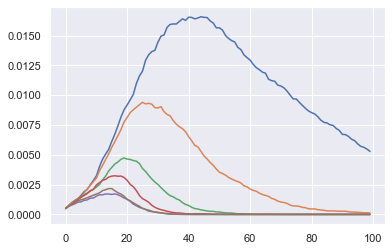

In [7]:
for aa in range(len(alerts)):
    plt.plot(i_t[aa])